In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# xlsx -> csv
# exposure = pd.read_excel('./기초데이터/익스포져.xlsx')
# claim = pd.concat([pd.read_excel('./기초데이터/지급보험금.xlsx'), pd.read_excel('./기초데이터/지급보험금_001.xlsx')])
# os = pd.read_excel('./기초데이터/개별추산액.xlsx')

# exposure.to_csv(path_or_buf='./data/exposure.csv', index=False)
# claim.to_csv(path_or_buf='./data/claim.csv', index=False)
# os.to_csv(path_or_buf='./data/os.csv', index=False)

In [3]:
exposure = pd.read_csv('./data/exposure.csv',dtype={'계약FY년월': str, '계약UY년월': str, 'FY': str, 'UY': str, '수입보험료': float, '경과보험료': float, '지급보험금': float, '전기OS': float, '후기OS': float, '손해조사비': float, '발생손해액': float})
claim = pd.read_csv('./data/claim.csv', dtype={'사고접수번호': str, '보험기간시작일자': str, '보험기간종료일자': str, '사고발생일자': str, '사고접수일자': str, '최초추산일자': str, '확정일자': str, '지급보험금': float, '손해조사비': float})
os = pd.read_csv('./data/os.csv', dtype={'사고접수번호': str, '보험기간시작일자': str, '보험기간종료일자': str, '사고발생일자': str, '사고접수일자': str, '최초추산일자': str, '확정일자': str, '개별추산액': float})

#### 1. 심도분석

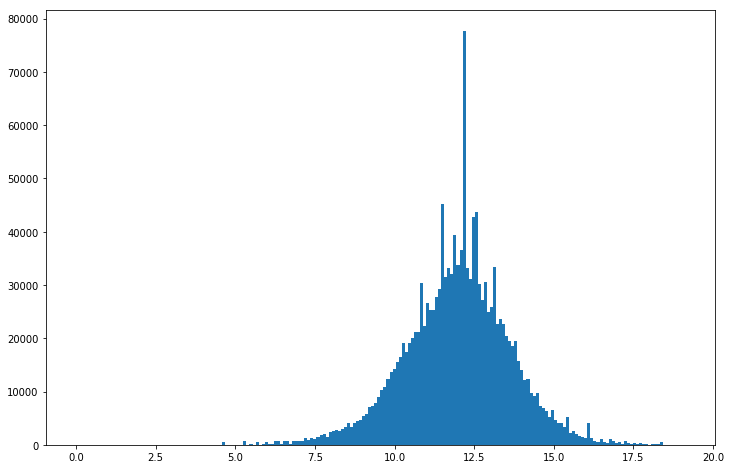

In [4]:
plt.figure(figsize=(12,8))
claim_filtered = claim.query('지급보험금 < 0.20e9 and 지급보험금 > 0')['지급보험금']
plt.hist(np.log(claim_filtered), bins=200)
plt.show()

In [5]:
mu = np.mean(np.log(claim_filtered))
sigma = np.std(np.log(claim_filtered))
mu, sigma

(11.989398049323801, 1.6489595226023832)

In [6]:
import scipy.stats
dist_name = 'norm'
severity = getattr(scipy.stats, dist_name)
severity = severity(loc=11.989, scale=1.649)

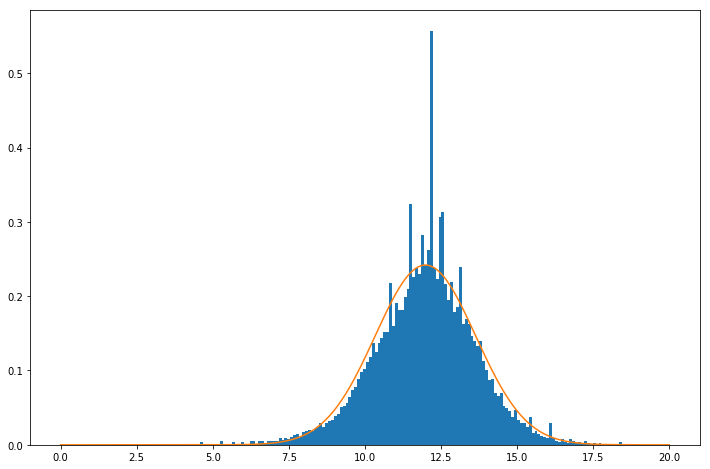

In [7]:
plt.figure(figsize=(12,8))
claim_filtered = claim.query('지급보험금 < 0.20e9 and 지급보험금 > 0')
x_range = np.linspace(0, 20, 200)
y = severity.pdf(x_range)
plt.hist(np.log(claim_filtered['지급보험금']), bins=200, density=True)
plt.plot(x_range, y)
plt.show()

#### 2. 빈도분석

In [8]:
claim_filtered['사고발생년월'] = claim_filtered.사고발생일자.str.slice(0, 6)
claim_filtered['사고발생년도'] = claim_filtered.사고발생일자.str.slice(0, 4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


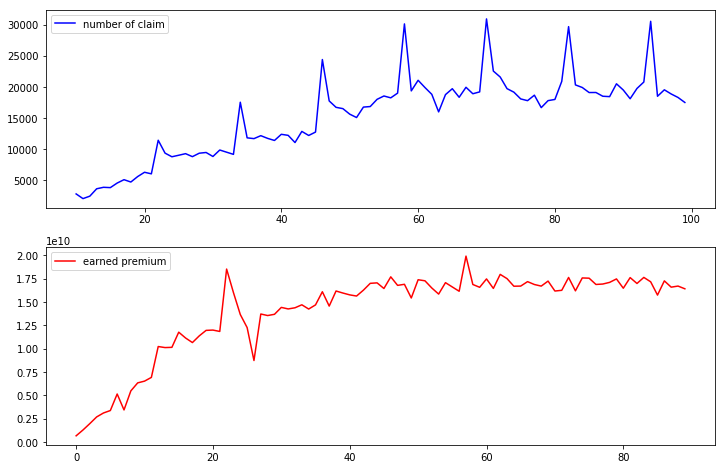

In [9]:
plt.figure(figsize=(12,8))
claim_count_monthly = claim_filtered.groupby('사고발생년월')['사고접수번호'].count().reset_index()
exposure_monthly = exposure.groupby('계약FY년월')['경과보험료'].sum().reset_index()

plt.subplot(2,1,1)
plt.plot(claim_count_monthly.query('사고발생년월 <= "201806" and 사고발생년월 >= "201101"')['사고접수번호'], color = 'blue', label='number of claim')
plt.legend(loc='upper left')

plt.subplot(2,1,2)
plt.plot(exposure_monthly.query('계약FY년월 <= "201806" and 계약FY년월 >= "201101"')['경과보험료'], color = 'red', label='earned premium')
plt.legend(loc='upper left')
plt.show()

In [17]:
claim_count_yearly = claim_filtered.groupby('사고발생년도')['사고접수번호'].count().reset_index()
exposure_yearly = exposure.groupby('FY')['경과보험료'].sum().reset_index()
exposure_2018 = exposure_yearly.query('FY == "2018"')['경과보험료'].values[0]
claim_count_adjusted = claim_count_yearly.query('사고발생년도 >= "2011"')['사고접수번호'].reset_index(drop=True)*exposure_2018/exposure_yearly['경과보험료']
claim_count_adjusted

0    212554.248684
1    152953.511753
2    182665.657163
3    216470.512123
4    235030.206559
5    235931.364949
6    234502.829290
7    210139.000000
dtype: float64

In [11]:
# total_claim = claim_count_monthly.query('사고발생년월 <= "201806" and 사고발생년월 >= "201307"')['사고접수번호'].sum()
# total_exposure = exposure_monthly.query('계약FY년월 <= "201806" and 계약FY년월 >= "201307"')['경과보험료'].sum()
# exposure_per_year = exposure_monthly.query('계약FY년월 <= "201806" and 계약FY년월 >= "201707"')['경과보험료'].sum()
# num_claim_per_year = (exposure_per_year/total_exposure)*total_claim
# num_claim_per_year, exposure_per_year

In [12]:
# dist_name = 'poisson'
# frequency = getattr(scipy.stats, 'poisson')
# frequency = frequency(mu=231900)

In [13]:
dist_name = 'nbinom'
frequency = getattr(scipy.stats, dist_name)
mu = claim_count_adjusted.mean()
sigma = claim_count_adjusted.std()
p = 1-(sigma**2-mu)/sigma**2
n = mu**2/(sigma**2-mu)
frequency = frequency(n, p)
n, p

(51.917377614253695, 0.000247128128946561)

#### 3. 시뮬레이션

In [14]:
num_scenario = 10000
Ns = frequency.rvs(num_scenario)
simulation_result = np.zeros(num_scenario)
np.random.seed(20190726)
for i in range(len(Ns)):
    simulation_result[i] = np.exp(severity.rvs(Ns[i])).sum()

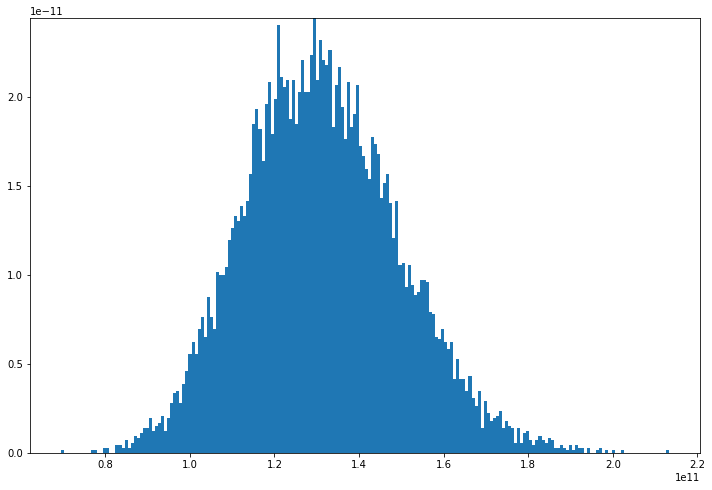

In [15]:
plt.figure(figsize=(12,8))
plt.hist(simulation_result, bins=200, density=True)
plt.show()

In [19]:
exposure_per_year = exposure_2018.copy()
lae_per_claim = claim_filtered['손해조사비'].sum()/claim_filtered['지급보험금'].sum()

expected_loss = simulation_result.mean()*(1+lae_per_claim)
loss_deviation = simulation_result.std()
loss_VaR = np.quantile(simulation_result, 0.995)*(1+lae_per_claim)

expected_loss_ratio = expected_loss / exposure_per_year
loss_ratio_deviation = loss_deviation / exposure_per_year
loss_ratio_VaR = loss_VaR / exposure_per_year
risk_coefficient = (loss_VaR - expected_loss) / exposure_per_year

In [20]:
unit = 100000000
print('예상 경과보험료: {:,.0f}억 원'.format(exposure_per_year/unit))
print()
print('예상 손해액: {:,.0f}억 원'.format(expected_loss/unit))
print('손해액 표준편차: {:,.0f}억 원'.format(loss_deviation/unit))
print('손해액 VaR(99.5%): {:,.0f}억 원'.format(loss_VaR/unit))
print()
print('예상 손해율: {:.2f}%'.format(expected_loss_ratio*100))
print('손해율 표준편차: {:.2f}%'.format(loss_ratio_deviation*100))
print('손해율 VaR(99.5%): {:.2f}%'.format(loss_ratio_VaR*100))
print()
print('위험계수: {:.2f}%'.format(risk_coefficient*100))

예상 경과보험료: 1,983억 원

예상 손해액: 1,352억 원
손해액 표준편차: 182억 원
손해액 VaR(99.5%): 1,884억 원

예상 손해율: 68.15%
손해율 표준편차: 9.18%
손해율 VaR(99.5%): 95.00%

위험계수: 26.85%
